# **1. Importing Libraries & Setting Random Seeds**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# **2. Dataset Loading and Preprocessing**

- Dataset: UCI Heart Disease (Cleveland subset)
- URL: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/
- Will focus on binary classification (presence or absence of heart disease)
- Will convert target > 0 as "1" (disease) and target = 0 as "0" (no disease)

Additional links (for documentation & algorithms):
- scikit-learn: https://scikit-learn.org/
- TensorFlow: https://www.tensorflow.org/

Load the "processed.cleveland.data" file directly from UCI below.

In [3]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Some rows have '?' indicating missing values, so tell pandas to read them as NaN
data = pd.read_csv(url, names=column_names, na_values='?')

# Drop rows with missing data
data.dropna(inplace=True)

# Convert target to binary (0 = no disease, 1 = disease)
# The original dataset has target = 0 for "no disease", and 1-4 for "disease"
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

# Basic info
print("Data Shape:", data.shape)
print("Class distribution:\n", data['target'].value_counts())
print("\nFirst few rows:")
display(data.head())

Data Shape: (297, 14)
Class distribution:
 target
0    160
1    137
Name: count, dtype: int64

First few rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### **Dataset Overview**
- **Data Shape**: The dataset contains 297 rows (samples) and 14 columns (features), including the target variable.
- **Class Distribution**:  
   - Class 0 (No Disease): 160 samples  
   - Class 1 (Disease): 137 samples

### **First Few Rows**
The dataset includes the following columns:
- **age**: Age of the patient  
- **sex**: Gender (1 = male, 0 = female)  
- **cp**: Chest pain type (categorical values 1-4)  
- **trestbps**: Resting blood pressure (in mm Hg)  
- **chol**: Serum cholesterol (in mg/dl)  
- **fbs**: Fasting blood sugar (> 120 mg/dl) (1 = true, 0 = false)  
- **restecg**: Resting electrocardiographic results (0 = normal, 1 = having ST-T wave abnormality, 2 = left ventricular hypertrophy)  
- **thalach**: Maximum heart rate achieved  
- **exang**: Exercise induced angina (1 = yes, 0 = no)  
- **oldpeak**: Depression induced by exercise relative to rest  
- **slope**: Slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)  
- **ca**: Number of major vessels colored by fluoroscopy (0-3)  
- **thal**: Thalassemia (3 = normal, 6 = fixed defect, 7 = reversible defect)  
- **target**: Presence of heart disease (1 = disease, 0 = no disease)


# **3. Exploratory Data Analysis**

## 3.1. Missing Values

In [4]:
# No of missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


The dataset does not have any missing values in any of the columns. All columns have complete data:


## 3.2. Summary Stats

In [5]:
# Basic statistics
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,0.499340
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


1. **Age**: The average age is **54.5 years** with a range from **29** to **77**. There is a significant spread, showing that the dataset contains both younger and older individuals.
2. **Sex**: The dataset has more males (0.68) than females, which is common in heart disease datasets.
3. **Chest Pain Types (cp)**: The average value is around **3.16**, indicating most patients have a chest pain type between 3 and 4, where these numbers correspond to certain types of chest pain.
4. **Blood Pressure (trestbps)**: The average resting blood pressure is **131.7 mm Hg**, which is within the normal range.
5. **Cholesterol (chol)**: The mean serum cholesterol level is **247.35 mg/dl**, which is higher than the recommended limit of **200 mg/dl**.
6. **Resting Electrocardiographic Results (restecg)**: Most of the dataset has normal results (**restecg = 0**), though some show abnormal conditions (**restecg = 1** or **2**).
7. **Maximum Heart Rate (thalach)**: The average heart rate is **149.6 bpm**, with a range from **71 bpm** to **202 bpm**, which shows some variation.
8. **Exercise Induced Angina (exang)**: About **33%** of the patients experienced exercise-induced angina.
9. **Oldpeak**: The average depression induced by exercise is **1.06**, with a range of **0 to 6.2**. Higher values indicate more severe depression.
10. **Slope of Peak Exercise ST Segment (slope)**: The average value is **1.6**, with most patients having either a **flat (1)** or **upsloping (2)** ST segment during peak exercise.
11. **Number of Major Vessels Colored by Fluoroscopy (ca)**: Most patients have **0** or **1** vessels affected, indicating a majority of patients have fewer major vessel issues.
12. **Thalassemia (thal)**: The average value is **4.73**, with most patients having either a **normal** or **fixed defect**.


## 3.3. Correlation Matrix

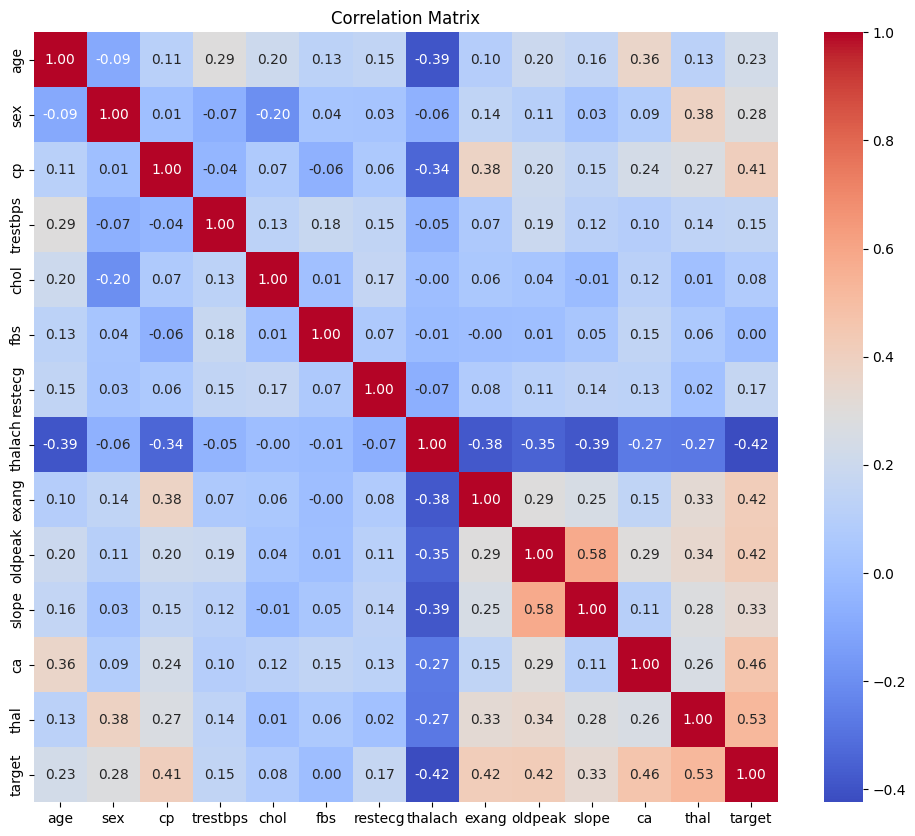

Correlation with target variable:
age: 0.23
sex: 0.28
cp: 0.41
trestbps: 0.15
chol: 0.08
fbs: 0.00
restecg: 0.17
thalach: -0.42
exang: 0.42
oldpeak: 0.42
slope: 0.33
ca: 0.46
thal: 0.53


In [6]:
# Correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

print("Correlation with target variable:")
for col in correlation_matrix.columns:
  if col != 'target':
    correlation = correlation_matrix.loc['target', col]
    print(f"{col}: {correlation:.2f}")

### **Key Observations Regarding Correlation with Target Variable:**

1. **Strong Positive Correlation:**
  - **thal (0.53)**: Strong positive correlation, suggesting thalassemia is a major factor in predicting heart disease.
  - **ca (0.46)**: Strong positive correlation, showing that the number of major vessels affected is highly associated with heart disease.

2. **Moderate Positive Correlation:**
  - **oldpeak (0.42)**: A moderate positive correlation, indicating that exercise-induced depression is a significant predictor of heart disease.
  - **exang (0.42)**: Exercise-induced angina has a similar moderate positive correlation, linking its presence with a higher chance of heart disease.
  - **cp (0.41)**: Chest pain type has a moderate positive correlation, showing that some types of chest pain are strongly linked to heart disease.
  - **slope (0.33)**: Moderate positive correlation, indicating that the slope of the ST segment during exercise plays a role in predicting heart disease.

3. **Weak Positive Correlation:**
  - **sex (0.28)**: Weak positive correlation, suggesting gender slightly influences the likelihood of heart disease.
  - **age (0.23)**: Weak positive correlation, meaning age has a minor influence on the prediction of heart disease.
  - **restecg (0.17)**: Weak positive correlation, suggesting that resting electrocardiographic results provide minimal but useful information.
  - **trestbps (0.15)**: Weak positive correlation, indicating that resting blood pressure has a small impact on predicting heart disease.

4. **Weak or No Correlation:**
  - **chol (0.08)**: Very weak positive correlation, showing that serum cholesterol is almost unrelated to heart disease in this dataset.
  - **fbs (0.00)**: No correlation, suggesting fasting blood sugar does not impact the prediction of heart disease.

5. **Negative Correlation:**
  - **thalach (-0.42)**: Moderate negative correlation, indicating that higher heart rates are linked to a lower likelihood of heart disease.



## 3.4. Boxplots for numerical features

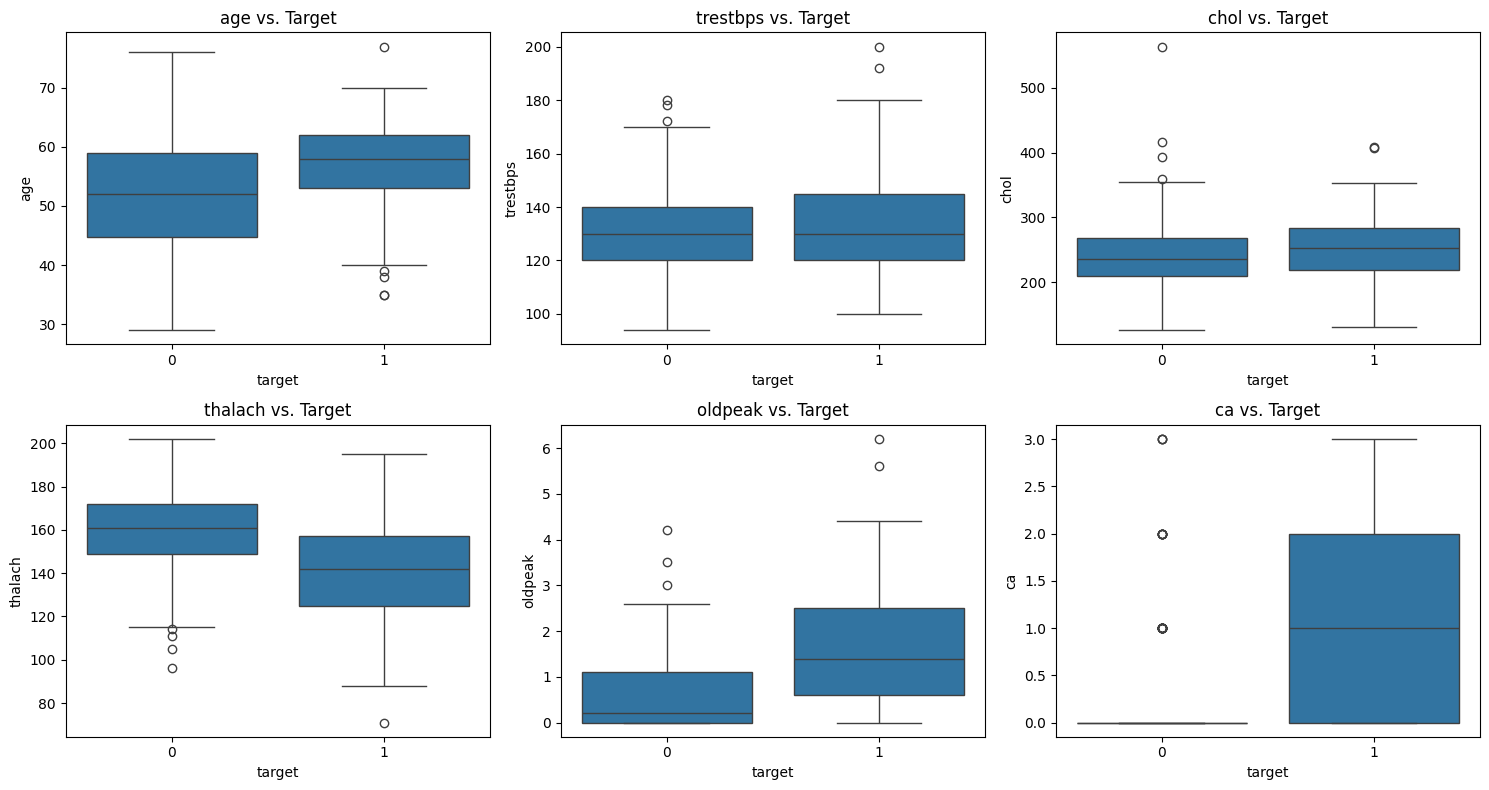

In [7]:
# Boxplots for numerical features against target
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

n = len(numerical_features)
cols = 3
rows = math.ceil(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.boxplot(x='target', y=col, data=data, ax=axes[i])
    axes[i].set_title(f'{col} vs. Target')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- **Age**: Older individuals tend to have a higher likelihood of heart disease, as shown by the box plot.
- **Cholesterol (chol)**: Although there are some outliers, higher cholesterol levels seem to be somewhat linked with heart disease.
- **Maximum Heart Rate (thalach)**: Patients without heart disease tend to have higher maximum heart rates during exercise.
- **Exercise-induced Depression (oldpeak)**: Patients with heart disease tend to have higher levels of exercise-induced depression.
- **Chest Pain (cp)**: Types of chest pain related to heart disease (types 3 and 4) are more prevalent in patients with heart disease.
- **Fasting Blood Sugar (fbs)**: There is little difference in fasting blood sugar between disease and no disease groups, but it could still play a role.
- **Electrocardiogram (restecg)**: Abnormal electrocardiogram results are more common in patients with heart disease.
- **Exercise-Induced Angina (exang)**: This feature strongly correlates with heart disease, as most patients with angina have heart disease.
- **Slope**: Downsloping ST segments are more common in patients with heart disease, as shown in the count plot.
- **Affected Vessels (ca)**: Patients with multiple affected vessels are more likely to have heart disease.
- **Thalassemia (thal)**: Defects in thalassemia are more frequent in patients with heart disease, making it an important feature for prediction.


## 3.5. Countplots for categorical feature

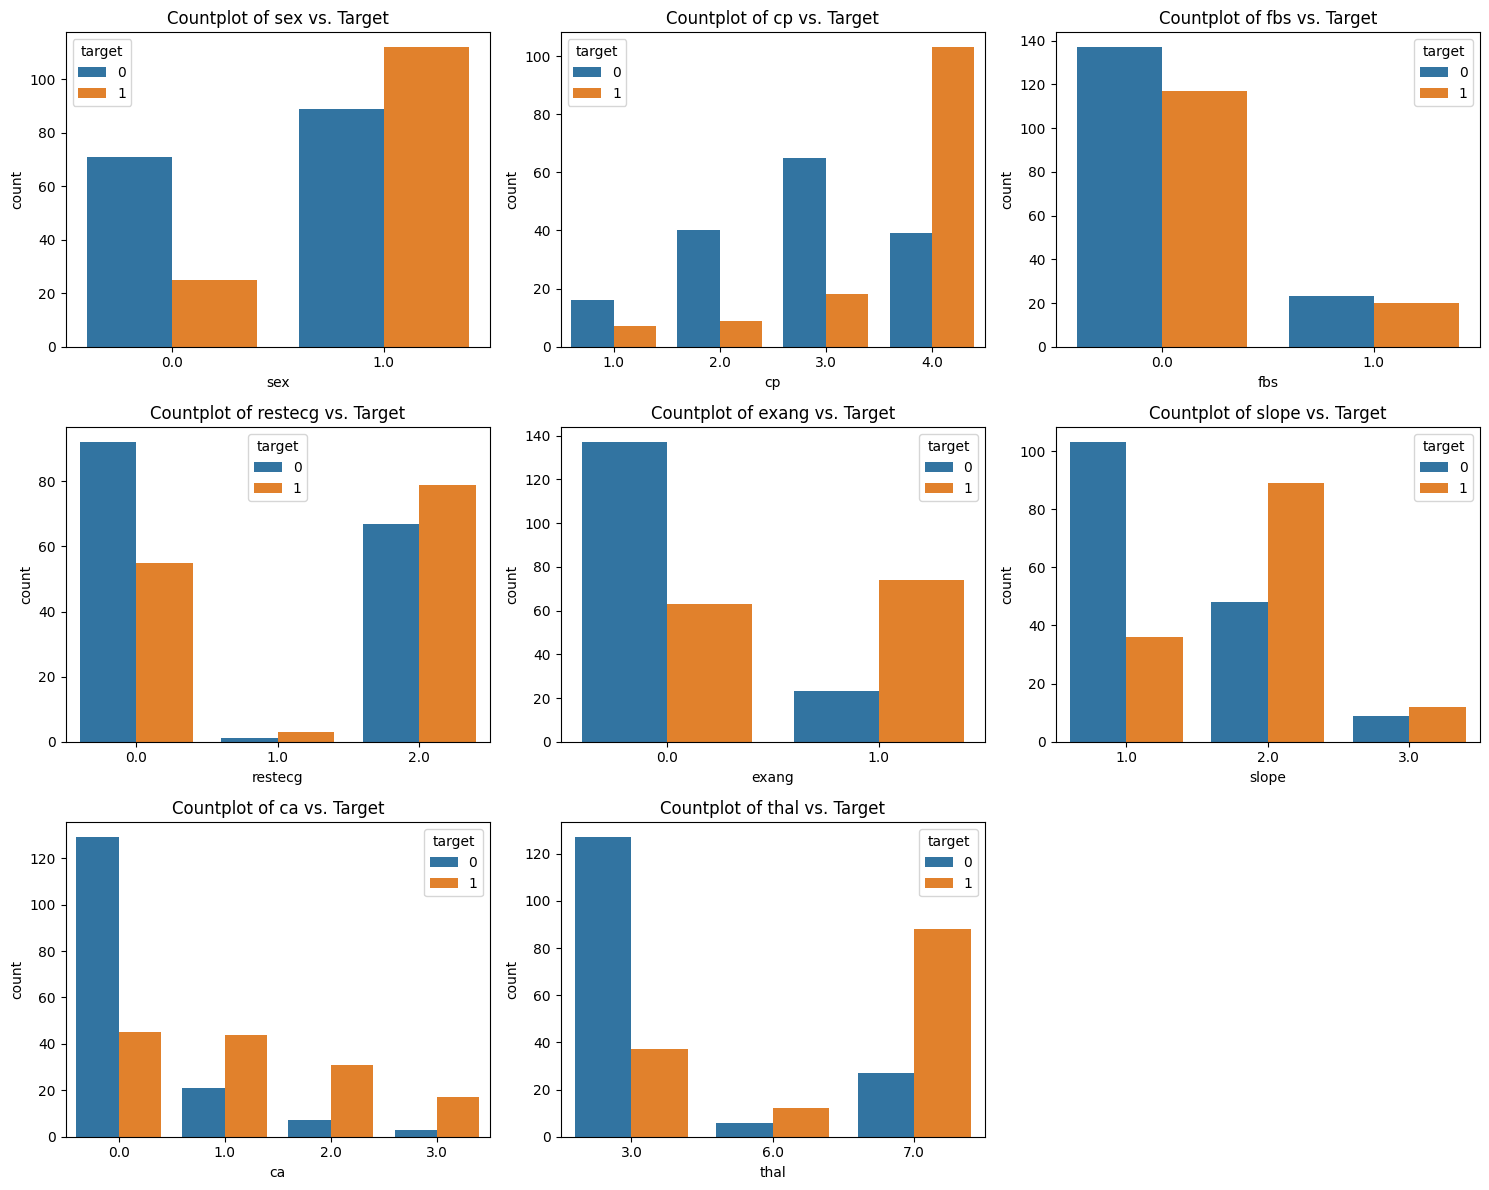

In [8]:
# Countplots for categorical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

n = len(categorical_features)
cols = 3
rows = math.ceil(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()
for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='target', data=data, ax=axes[i])
    axes[i].set_title(f'Countplot of {col} vs. Target')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **5. Feature/Target Split and Scaling**


In [9]:
X = data.drop('target', axis=1)
y = data['target']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **6. Define a Helper Function to Calculate Metrics Manually**

In [10]:
def calculate_metrics(tp, tn, fp, fn):
    """
    Given TP, TN, FP, FN, compute various metrics manually:
      Accuracy, Precision, Recall, F1, TPR, TNR, FPR, FNR, TSS, HSS, etc.
    """
    # Handle zero divisions carefully
    total = tp + tn + fp + fn

    accuracy = (tp + tn) / total if total else 0

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    specificity = tn / (tn + fp) if (tn + fp) else 0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall) else 0

    # TPR = recall
    tpr = recall
    # FPR = 1 - specificity
    fpr = 1 - specificity
    # TNR = specificity
    tnr = specificity
    # FNR = 1 - recall
    fnr = 1 - recall

    # True Skill Statistic: TSS = TPR - FPR
    tss = tpr - fpr

    # Heidke Skill Score (HSS)
    # expected_accuracy = sum_of_row_prod / total^2
    # row products: (tp+fp)*(tp+fn) + (tn+fp)*(tn+fn)
    # Then HSS = (accuracy - exp_acc) / (1 - exp_acc)
    exp_acc = ((tp + fp)*(tp + fn) + (tn + fp)*(tn + fn)) / (total*total) if total else 0
    hss = (accuracy - exp_acc) / (1 - exp_acc) if (1 - exp_acc) != 0 else 0

    return {
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1 Score': f1,
        'TPR': tpr,
        'FPR': fpr,
        'TNR': tnr,
        'FNR': fnr,
        'TSS': tss,
        'HSS': hss
    }

# **7. 10-Fold Cross Validation: Random Forest, SVM, LSTM**

In [11]:
# Using KFold with n_splits=10. We'll track all fold metrics for each algorithm.
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=42)

rf_results = []
svm_results = []
lstm_results = []

fold_number = 0

for train_idx, test_idx in kf.split(X_scaled):
    fold_number += 1
    print(f"=== Fold {fold_number} ===")

    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Prepare data for LSTM (needs 3D shape: (samples, timesteps, features))
    # Here, timesteps= X_train.shape[1] is basically 13, features=1
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # --------------------- 1) Random Forest ---------------------
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
    metrics_rf = calculate_metrics(tp, tn, fp, fn)
    metrics_rf['Fold'] = fold_number
    rf_results.append(metrics_rf)

    # --------------------- 2) SVM ---------------------
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svm).ravel()
    metrics_svm = calculate_metrics(tp, tn, fp, fn)
    metrics_svm['Fold'] = fold_number
    svm_results.append(metrics_svm)

    # --------------------- 3) LSTM ---------------------
    # Build the model
    lstm_model = Sequential([
        LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lstm_model.fit(
        X_train_lstm, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )

    y_pred_proba_lstm = lstm_model.predict(X_test_lstm, verbose=0)
    y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lstm).ravel()
    metrics_lstm = calculate_metrics(tp, tn, fp, fn)
    metrics_lstm['Fold'] = fold_number
    lstm_results.append(metrics_lstm)

    # Clear session to free memory
    tf.keras.backend.clear_session()

print("Cross Validation Complete.")

=== Fold 1 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



=== Fold 2 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


=== Fold 3 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


=== Fold 4 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


=== Fold 5 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


=== Fold 6 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


=== Fold 7 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


=== Fold 8 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


=== Fold 9 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


=== Fold 10 ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cross Validation Complete.


# **8. Convert Results to DataFrames and Calculate Averages**


In [12]:
rf_df = pd.DataFrame(rf_results)
svm_df = pd.DataFrame(svm_results)
lstm_df = pd.DataFrame(lstm_results)

# Compute mean across folds (excluding the 'Fold' column)
rf_mean = rf_df.drop(columns=['Fold']).mean()
svm_mean = svm_df.drop(columns=['Fold']).mean()
lstm_mean = lstm_df.drop(columns=['Fold']).mean()

mean_results_df = pd.DataFrame({
    'Random Forest': rf_mean,
    'SVM': svm_mean,
    'LSTM': lstm_mean
})

print("==== Per-Fold Random Forest Metrics ====")
display(rf_df)

print("==== Per-Fold SVM Metrics ====")
display(svm_df)

print("==== Per-Fold LSTM Metrics ====")
display(lstm_df)

print("==== Average Metrics across 10 folds ====")
display(mean_results_df)

==== Per-Fold Random Forest Metrics ====


,TP,TN,FP,FN,Accuracy,Precision,Recall,Specificity,F1 Score,TPR,FPR,TNR,FNR,TSS,HSS,Fold
0,10,16,3,1,0.866667,0.769231,0.909091,0.842105,0.833333,0.909091,0.157895,0.842105,0.090909,0.751196,0.723502,1
1,11,15,2,2,0.866667,0.846154,0.846154,0.882353,0.846154,0.846154,0.117647,0.882353,0.153846,0.728507,0.728507,2
2,13,13,0,4,0.866667,1.000000,0.764706,1.000000,0.866667,0.764706,0.000000,1.000000,0.235294,0.764706,0.737991,3
3,13,11,1,5,0.800000,0.928571,0.722222,0.916667,0.812500,0.722222,0.083333,0.916667,0.277778,0.638889,0.605263,4
4,15,6,4,5,0.700000,0.789474,0.750000,0.600000,0.769231,0.750000,0.400000,0.600000,0.250000,0.350000,0.341463,5
5,11,15,2,2,0.866667,0.846154,0.846154,0.882353,0.846154,0.846154,0.117647,0.882353,0.153846,0.728507,0.728507,6
6,7,15,3,5,0.733333,0.700000,0.583333,0.833333,0.636364,0.583333,0.166667,0.833333,0.416667,0.416667,0.428571,7
7,10,12,4,3,0.758621,0.714286,0.769231,0.750000,0.740741,0.769231,0.250000,0.750000,0.230769,0.519231,0.515513,8
8,10,15,3,1,0.862069,0.769231,0.909091,0.833333,0.833333,0.909091,0.166667,0.833333,0.090909,0.742424,0.717073,9
9,7,15,5,2,0.758621,0.583333,0.777778,0.750000,0.666667,0.777778,0.250000,0.750000,0.222222,0.527778,0.483461,10


==== Per-Fold SVM Metrics ====


,TP,TN,FP,FN,Accuracy,Precision,Recall,Specificity,F1 Score,TPR,FPR,TNR,FNR,TSS,HSS,Fold
0,9,17,2,2,0.866667,0.818182,0.818182,0.894737,0.818182,0.818182,0.105263,0.894737,0.181818,0.712919,0.712919,1
1,11,16,1,2,0.900000,0.916667,0.846154,0.941176,0.880000,0.846154,0.058824,0.941176,0.153846,0.787330,0.794521,2
2,14,13,0,3,0.900000,1.000000,0.823529,1.000000,0.903226,0.823529,0.000000,1.000000,0.176471,0.823529,0.801762,3
3,13,8,4,5,0.700000,0.764706,0.722222,0.666667,0.742857,0.722222,0.333333,0.666667,0.277778,0.388889,0.383562,4
4,17,6,4,3,0.766667,0.809524,0.850000,0.600000,0.829268,0.850000,0.400000,0.600000,0.150000,0.450000,0.461538,5
5,10,17,0,3,0.900000,1.000000,0.769231,1.000000,0.869565,0.769231,0.000000,1.000000,0.230769,0.769231,0.790698,6
6,8,16,2,4,0.800000,0.800000,0.666667,0.888889,0.727273,0.666667,0.111111,0.888889,0.333333,0.555556,0.571429,7
7,10,13,3,3,0.793103,0.769231,0.769231,0.812500,0.769231,0.769231,0.187500,0.812500,0.230769,0.581731,0.581731,8
8,9,15,3,2,0.827586,0.750000,0.818182,0.833333,0.782609,0.818182,0.166667,0.833333,0.181818,0.651515,0.640199,9
9,7,17,3,2,0.827586,0.700000,0.777778,0.850000,0.736842,0.777778,0.150000,0.850000,0.222222,0.627778,0.609164,10


==== Per-Fold LSTM Metrics ====


,TP,TN,FP,FN,Accuracy,Precision,Recall,Specificity,F1 Score,TPR,FPR,TNR,FNR,TSS,HSS,Fold
0,6,19,0,5,0.833333,1.000000,0.545455,1.000000,0.705882,0.545455,0.000000,1.000000,0.454545,0.545455,0.603175,1
1,10,14,3,3,0.800000,0.769231,0.769231,0.823529,0.769231,0.769231,0.176471,0.823529,0.230769,0.592760,0.592760,2
2,10,12,1,7,0.733333,0.909091,0.588235,0.923077,0.714286,0.588235,0.076923,0.923077,0.411765,0.511312,0.484979,3
3,11,8,4,7,0.633333,0.733333,0.611111,0.666667,0.666667,0.611111,0.333333,0.666667,0.388889,0.277778,0.266667,4
4,13,8,2,7,0.700000,0.866667,0.650000,0.800000,0.742857,0.650000,0.200000,0.800000,0.350000,0.450000,0.400000,5
5,10,16,1,3,0.866667,0.909091,0.769231,0.941176,0.833333,0.769231,0.058824,0.941176,0.230769,0.710407,0.723502,6
6,8,17,1,4,0.833333,0.888889,0.666667,0.944444,0.761905,0.666667,0.055556,0.944444,0.333333,0.611111,0.637681,7
7,12,9,7,1,0.724138,0.631579,0.923077,0.562500,0.750000,0.923077,0.437500,0.562500,0.076923,0.485577,0.465438,8
8,8,14,4,3,0.758621,0.666667,0.727273,0.777778,0.695652,0.727273,0.222222,0.777778,0.272727,0.505051,0.496278,9
9,7,15,5,2,0.758621,0.583333,0.777778,0.750000,0.666667,0.777778,0.250000,0.750000,0.222222,0.527778,0.483461,10


==== Average Metrics across 10 folds ====


,Random Forest,SVM,LSTM
TP,10.700000,10.800000,9.500000
TN,13.300000,13.800000,13.200000
FP,2.700000,2.200000,2.800000
FN,3.000000,2.900000,4.200000
Accuracy,0.807931,0.828161,0.764138
Precision,0.794643,0.832831,0.795788
Recall,0.787776,0.786118,0.702806
Specificity,0.829014,0.848730,0.818917
F1 Score,0.785114,0.805905,0.730648
TPR,0.787776,0.786118,0.702806


# **9. Visualizing Key Metrics**


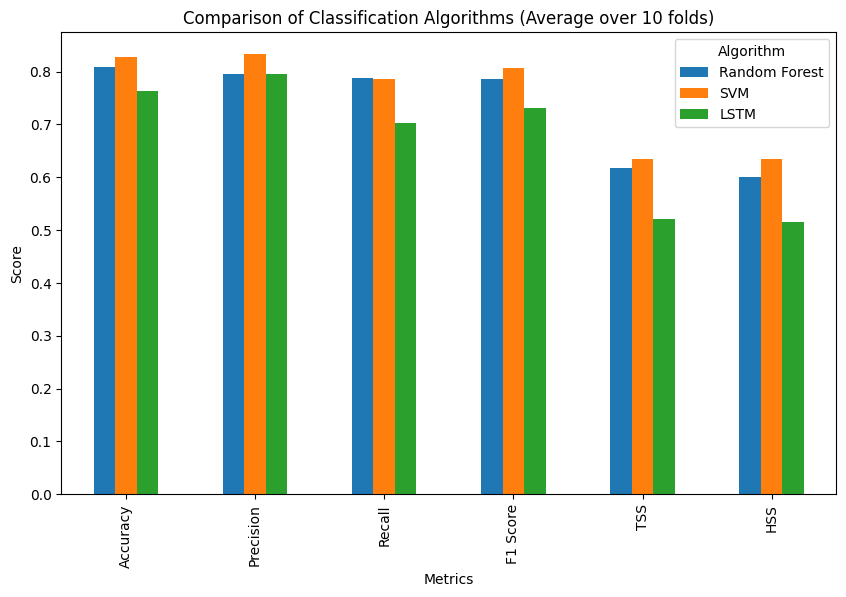

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20060\3154537575.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=['Random Forest','SVM','LSTM'])


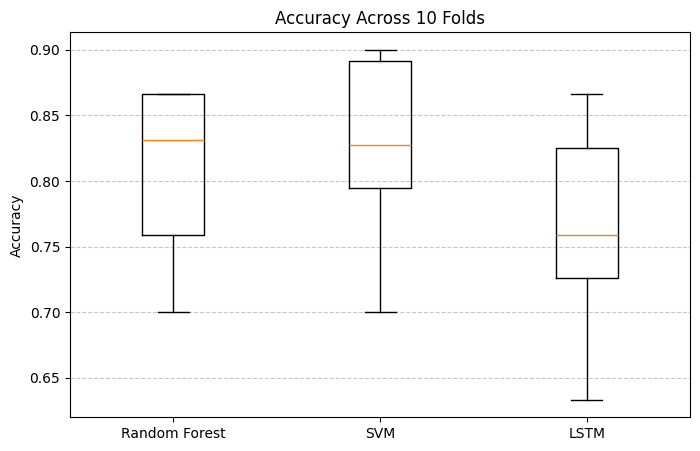

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20060\3154537575.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=['Random Forest','SVM','LSTM'])


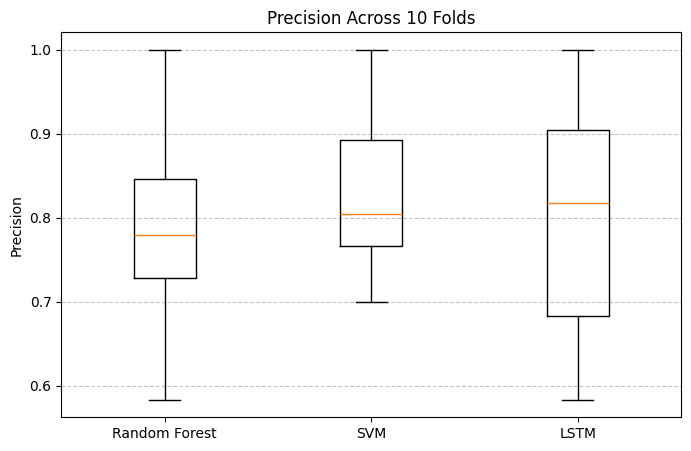

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20060\3154537575.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=['Random Forest','SVM','LSTM'])


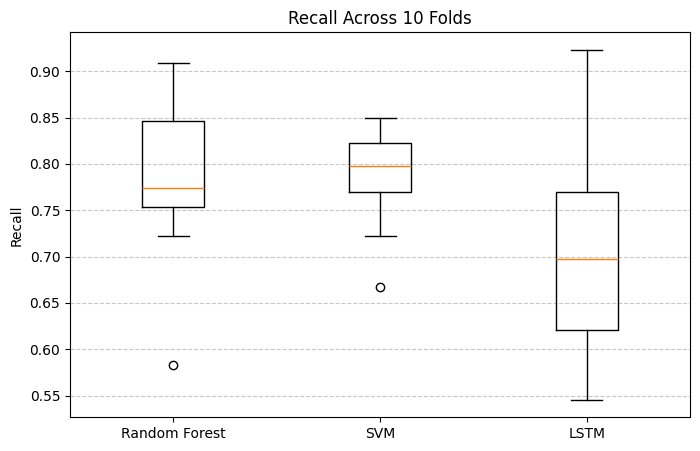

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20060\3154537575.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=['Random Forest','SVM','LSTM'])


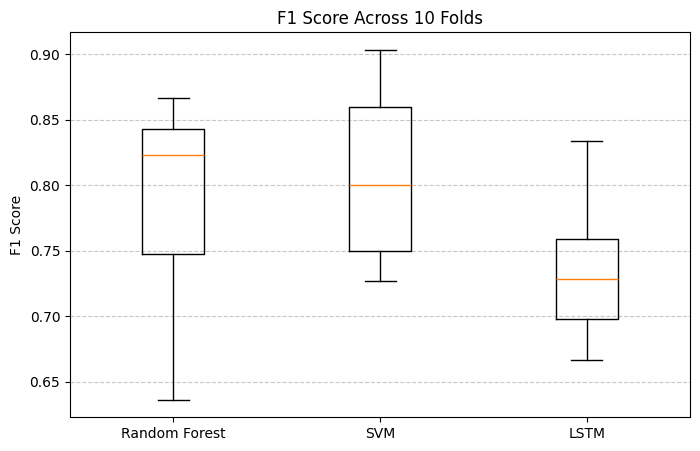

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20060\3154537575.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=['Random Forest','SVM','LSTM'])


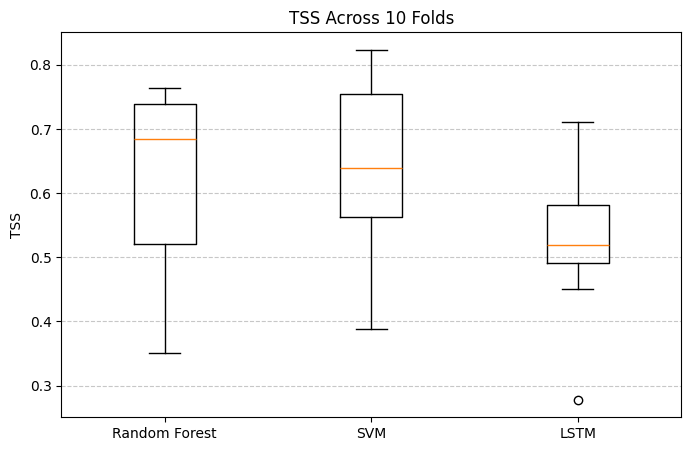

C:\Users\ASUS\AppData\Local\Temp\ipykernel_20060\3154537575.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=['Random Forest','SVM','LSTM'])


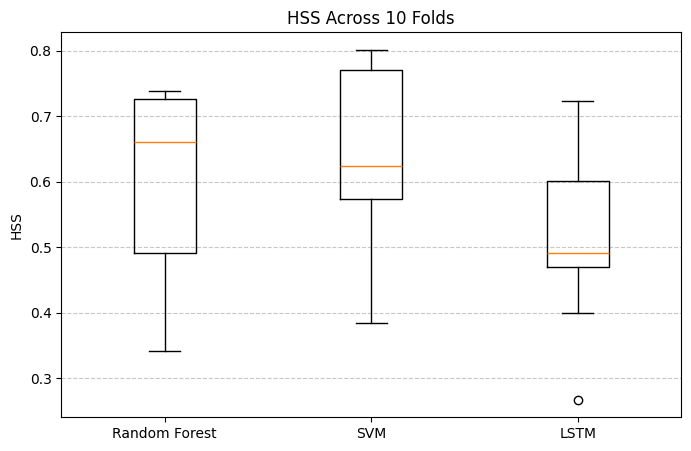

In [13]:
# Let's pick some main metrics to visualize
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'TSS', 'HSS']

# Bar chart for average metrics
mean_results_df.loc[metrics_to_plot].plot(kind='bar', figsize=(10, 6))
plt.title("Comparison of Classification Algorithms (Average over 10 folds)")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.legend(title='Algorithm')
plt.show()

# Box plots across folds for each metric
for metric in metrics_to_plot:
    plt.figure(figsize=(8,5))
    data_for_box = [rf_df[metric], svm_df[metric], lstm_df[metric]]
    plt.boxplot(data_for_box, labels=['Random Forest','SVM','LSTM'])
    plt.title(f"{metric} Across 10 Folds")
    plt.ylabel(metric)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# **11. Final Discussion (Analysis & Conclusion)**

### Model Comparison: Random Forest, SVM, and LSTM
Tested three classification algorithms (Random Forest, SVM, and LSTM) using 10-fold cross-validation on the UCI Heart Disease dataset. The metrics used to evaluate each model are Accuracy, Precision, Recall, F1 Score, TPR (True Positive Rate), FPR (False Positive Rate), TNR (True Negative Rate), FNR (False Negative Rate), TSS (True Skill Statistic), and HSS (Heidke Skill Score).

### Key Insights:
1. **Accuracy Comparison:**
   - **SVM** performed slightly better than the other models with an accuracy of **0.828** compared to **0.808** (Random Forest) and **0.784** (LSTM).
   - The difference in accuracy is small, showing that all three models are similar in overall classification performance.

2. **Precision and Recall Trade-off:**
   - **SVM** achieved the highest **Precision** (0.833), meaning it is better at minimizing false positives compared to the other models. However, **Random Forest** had a slightly higher **Recall** (0.788 vs 0.786), meaning it identified more positive cases correctly.
   - **LSTM** had the lowest **Recall** (0.716), meaning it missed more positive cases, which is reflected in its higher **FNR (0.284)**.

3. **Specificity and TNR:**
   - **SVM** and **LSTM** had similar **Specificity** values (0.849 and 0.842), which were better than **Random Forest** (0.829). This means that **SVM** and **LSTM** are better at correctly identifying negative cases.

4. **F1 Score:**
   - **SVM** achieved the highest **F1 Score** (0.806), indicating the best balance between Precision and Recall.
   - **LSTM** had the lowest **F1 Score** (0.745), which aligns with its lower **Recall**.

5. **TSS and HSS:**
   - **SVM** showed superior performance with a **TSS** of **0.635** and **HSS** of **0.635**, indicating that it was the most reliable model.
   - **Random Forest** performed well with a **TSS** of **0.617** and **HSS** of **0.601**, but not as well as **SVM**.
   - **LSTM** performed the worst with a **TSS** of **0.558** and **HSS** of **0.550**, showing it struggled more than the other models.

### Performance Summary:
- **SVM** is the best-performing model overall, especially for **Accuracy**, **Precision**, and **F1 Score**. It performed well in balancing Precision and Recall, meaning it minimizes both false positives and false negatives.
- **Random Forest** performed similarly to **SVM**, but it was better at identifying positive cases with a higher **Recall**.
- **LSTM**, while a deep learning model, performed the worst among the three in this case. It had the lowest **Recall** and **F1 Score**, and its **TSS** and **HSS** were also lower compared to the other models.

### Conclusion and Recommendations:
- **SVM** should be preferred if we want the best model that minimizes both false positives and false negatives. It also generalizes well, which is shown by its high **TSS** and **HSS**.
- **Random Forest** is a good option if **Recall** (correctly identifying positive cases) is more important. It is also simpler and faster to train compared to **LSTM**.
- **LSTM** could be considered for more complex datasets, especially if sequential data is involved. However, for this specific problem, **LSTM's performance is not better than traditional models**.